In [61]:
import os
import time
import collections
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from PIL import Image
%matplotlib inline

## Import object_detection modules from tensorflow/model

In [62]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Model and path setup

In [63]:
# What model to use
MODEL_NAME = 'ssd_inception_v2_coco_11_06_2017_udacity_real_inference_graph'
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training_data', 'tl_label_map.pbtxt')

NUM_CLASSES = 4

PATH_TO_TEST_IMAGES_DIR = 'test_images_real'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'left0000.jpg'),
                    os.path.join(PATH_TO_TEST_IMAGES_DIR, 'left0285.jpg'),
                    os.path.join(PATH_TO_TEST_IMAGES_DIR, 'left0350.jpg'),
                    os.path.join(PATH_TO_TEST_IMAGES_DIR, 'left0382.jpg')]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

detection_graph = tf.Graph()

## Load frozen model defined above

In [64]:
def load_frozen_model():
  with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
      serialized_graph = fid.read()
      od_graph_def.ParseFromString(serialized_graph)
      tf.import_graph_def(od_graph_def, name='')  

## Load labels and label_index from label_map file

In [65]:
def load_label_map():
  label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
  categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
  category_index = label_map_util.create_category_index(categories)  
  return categories, category_index

## Helper functions

In [66]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [67]:
def get_category(categories, index):
  for category in categories:
    if category['id'] == index:
      return category
  return None

In [68]:
def extract_box(box_tuple, image):
  ymin, xmin, ymax, xmax = box_tuple[0]
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, 
                                xmax * im_width, 
                                ymin * im_height, 
                                ymax * im_height) 
  return (int(left), int(right), int(top), int(bottom))

## Main predict function

In [69]:
def predict(categories, category_index):
  with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
      # Definite input and output Tensors for detection_graph
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
      detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        
        time_start = time.time()        
        # Actual detection.
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})    
        time_end = time.time()
        detection_time_ms = (time_end - time_start) * 1000.0
        
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8)

        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)
        plt.show()
        
        print(os.path.basename(image_path))
        print("Detection time(ms):{}".format(detection_time_ms))
        print("\tBounding box for the highest score object (l,r,t,b):{}".format(extract_box(tuple(boxes[0].tolist()), image)))
        # pick the highest score for now
        for i in range(3):
          score = scores[0][i]
          class_index = int(classes[0][i])
          category = get_category(categories, class_index)
          if category is not None:
            print("\tRank:{} label:{} class_index:{} prob:{:0.4f}".format(i, category['name'], class_index, score))

        counted = collections.Counter(classes.tolist()[0])
        most_common_class_index=int(counted.most_common()[0][0])
        category = get_category(categories, most_common_class_index)
        if category is not None:
          print("\tMost commonly identified label:{}".format(category['name']))

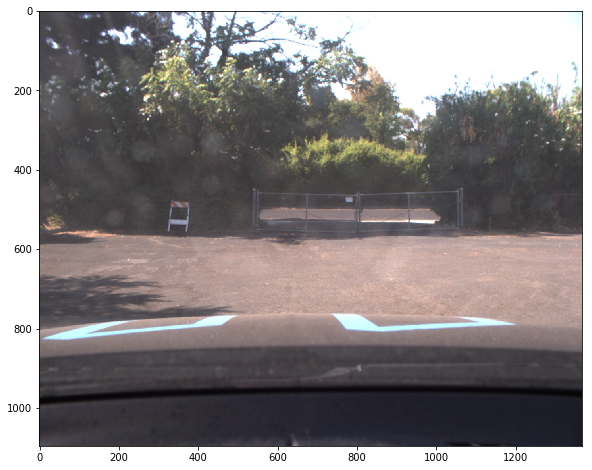

left0000.jpg
Detection time(ms):2107.3081493377686
	Bounding box for the highest score object (l,r,t,b):(329, 368, 452, 543)
	Rank:0 label:Red class_index:1 prob:0.0098
	Rank:1 label:Green class_index:3 prob:0.0031
	Rank:2 label:Yellow class_index:2 prob:0.0005
	Most commonly identified label:Unknown


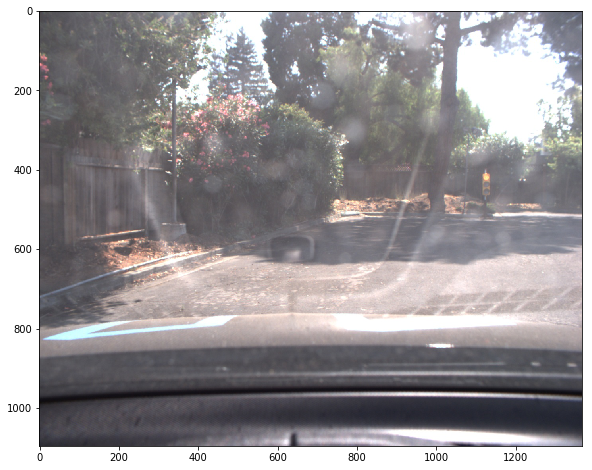

left0285.jpg
Detection time(ms):318.6368942260742
	Bounding box for the highest score object (l,r,t,b):(1124, 1147, 403, 460)
	Rank:0 label:Red class_index:1 prob:0.0129
	Rank:1 label:Yellow class_index:2 prob:0.0022
	Rank:2 label:Green class_index:3 prob:0.0009
	Most commonly identified label:Red


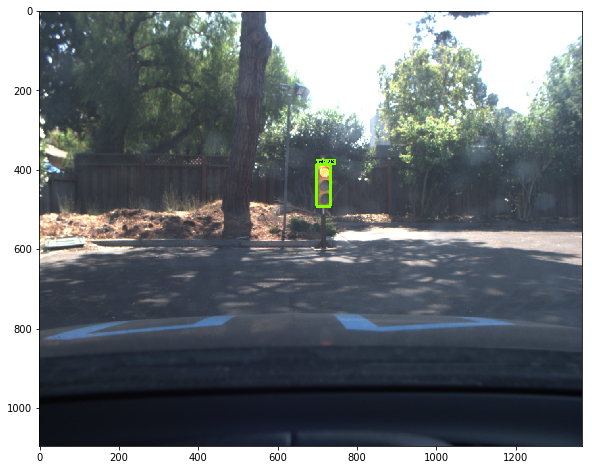

left0350.jpg
Detection time(ms):293.2569980621338
	Bounding box for the highest score object (l,r,t,b):(698, 735, 386, 491)
	Rank:0 label:Red class_index:1 prob:0.9987
	Rank:1 label:Green class_index:3 prob:0.0006
	Rank:2 label:Red class_index:1 prob:0.0004
	Most commonly identified label:Unknown


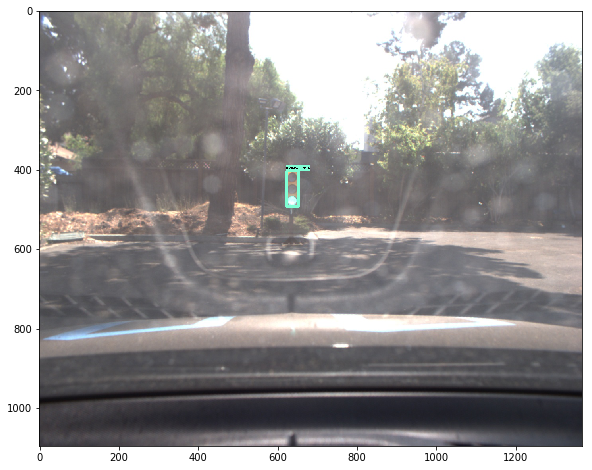

left0382.jpg
Detection time(ms):223.65522384643555
	Bounding box for the highest score object (l,r,t,b):(622, 653, 402, 492)
	Rank:0 label:Green class_index:3 prob:0.9997
	Rank:1 label:Red class_index:1 prob:0.0003
	Rank:2 label:Red class_index:1 prob:0.0003
	Most commonly identified label:Red


In [70]:
  load_frozen_model()
  categories, category_index = load_label_map()
  predict(categories, category_index)